STARTING RQ3 ANALYSIS
Research Question: How does PR description length affect merge outcome?
Starting RQ3 Analysis: Reading cleaned_data.csv...
Data loaded successfully. Shape: (859927, 26)
Columns in data: ['id_x', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'id_y', 'url', 'license', 'full_name', 'language', 'forks', 'stars', 'agent_name', 'is_merged', 'decision_time_hours', 'body_word_count', 'language_grouped']
Data Summary:
Total PRs: 859927
PRs with description: 851758
Unique values in is_merged column: [0]
After removing rows with missing values: 851758 (removed 8169 rows)

Data types:
is_merged dtype: int64
Unique values in is_merged: [0]
Converted is_merged to numeric: {0: 851758}

Description Length Statistics:
Minimum length: 1 characters
Maximum length: 96630 characters
Mean length: 506.5 characters
Median length: 294.0 characters

Filtered outliers (top 1%): 843246/851758 records

/var/folders/7g/570cwlg916g7pmb2m8x7h7zw0000gn/T/ipykernel_51192/3134496218.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_merged_category'] = df_filtered['is_merged_numeric'].map({0: 'Rejected', 1: 'Merged'})
/var/folders/7g/570cwlg916g7pmb2m8x7h7zw0000gn/T/ipykernel_51192/3134496218.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



SUMMARY STATISTICS TABLE
Metric               Rejected        Merged          Difference     
-----------------------------------------------------------------
Count                843246          0               -843246        
Mean                 435.2           nan             nan            
Median               292.0           nan             nan            
Std Dev              562.3           nan             nan            
Min                  1               nan             nan            
Max                  4559            nan             nan            

ANALYSIS COMPLETED
1. Dataset: 843246 PRs analyzed
2. Box plot saved: rq3_analysis.png
3. Distribution plot saved: rq3_analysis_distribution.png


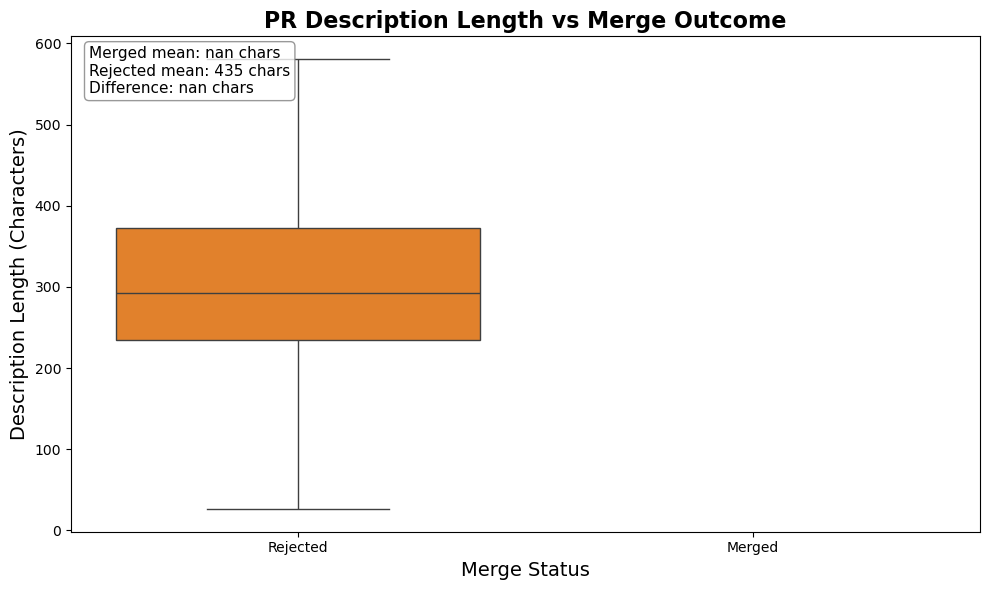

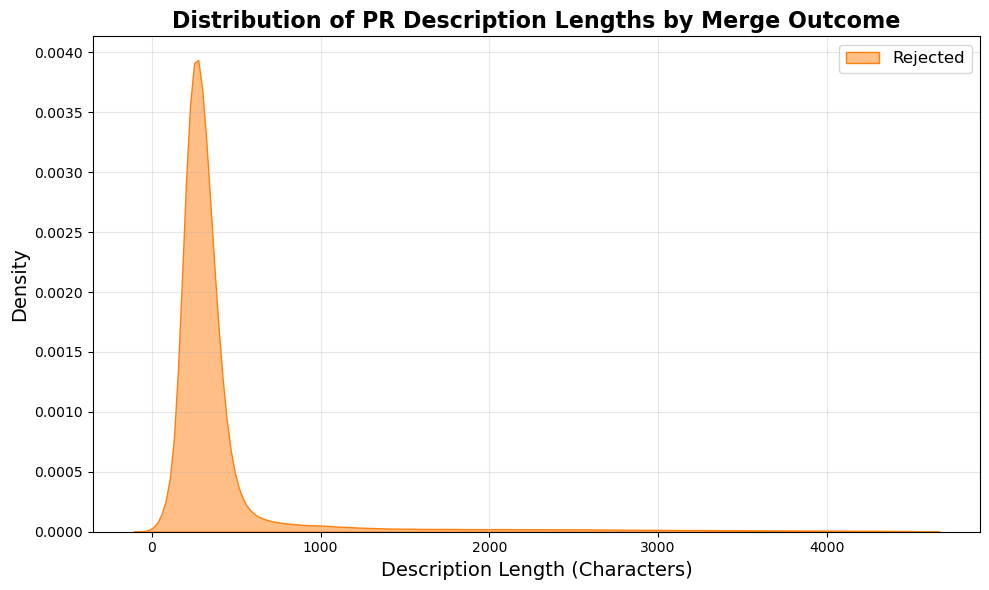

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from datetime import datetime

def analyze_rq3(input_file, output_image):
    """
    Analyze RQ3: Relationship between PR description length and merge outcome
    """
    print("="*40)
    print(f"Starting RQ3 Analysis: Reading {input_file}...")
    print("="*40)
    
    if not os.path.exists(input_file):
        print(f"ERROR: File '{input_file}' not found.")
        print("Please run cleaning.py first to generate the csv file.")
        return

    try:
        df = pd.read_csv(input_file)
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns in data: {list(df.columns)}")
    except Exception as e:
        print(f"ERROR loading CSV file: {str(e)}")
        return
    
    required_cols = ['body', 'is_merged']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        print("Checking for alternative column names...")
        
        if 'body' not in df.columns:
            body_candidates = [col for col in df.columns if 'description' in col.lower() or 'text' in col.lower() or 'content' in col.lower() or 'pr' in col.lower()]
            if body_candidates:
                print(f"Using '{body_candidates[0]}' instead of 'body'")
                df.rename(columns={body_candidates[0]: 'body'}, inplace=True)
            else:
                print("ERROR: Could not find description column.")
                return
        
        if 'is_merged' not in df.columns:
            merged_candidates = [col for col in df.columns if 'merged' in col.lower() or 'merge' in col.lower() or 'status' in col.lower() or 'state' in col.lower()]
            if merged_candidates:
                print(f"Using '{merged_candidates[0]}' instead of 'is_merged'")
                df.rename(columns={merged_candidates[0]: 'is_merged'}, inplace=True)
            else:
                print("ERROR: Could not find merge status column.")
                return
    
    print("="*40)
    print("Data Summary:")
    print(f"Total PRs: {len(df)}")
    print(f"PRs with description: {df['body'].notna().sum()}")
    print(f"Unique values in is_merged column: {df['is_merged'].unique()}")
    
    initial_count = len(df)
    df = df.dropna(subset=['body', 'is_merged'])
    print(f"After removing rows with missing values: {len(df)} (removed {initial_count - len(df)} rows)")
    
    if df.empty:
        print("ERROR: No data remaining after removing missing values.")
        return
    
    print(f"\nData types:")
    print(f"is_merged dtype: {df['is_merged'].dtype}")
    print(f"Unique values in is_merged: {df['is_merged'].unique()[:10]}")  
    
    try:
        df['is_merged_str'] = df['is_merged'].astype(str).str.lower().str.strip()
        merge_mapping = {
            'true': 1, 'false': 0,
            '1': 1, '0': 0,
            'yes': 1, 'no': 0,
            'merged': 1, 'rejected': 0,
            'open': 0, 'closed': 0,  
        }
        
        df['is_merged_numeric'] = df['is_merged_str'].map(merge_mapping)
        df['is_merged_numeric'] = df['is_merged_numeric'].fillna(0).astype(int)
        
        print(f"Converted is_merged to numeric: {df['is_merged_numeric'].value_counts().to_dict()}")
        
    except Exception as e:
        print(f"ERROR converting is_merged column: {str(e)}")
        print("Creating binary is_merged column from unique values...")
        unique_vals = df['is_merged'].unique()
        if len(unique_vals) == 2:
            df['is_merged_numeric'] = pd.factorize(df['is_merged'])[0]
        else:
            df['is_merged_numeric'] = 1  
        print(f"Created binary column: {df['is_merged_numeric'].value_counts().to_dict()}")
    
    df['description_length'] = df['body'].fillna('').apply(len)
    
    print("\nDescription Length Statistics:")
    print(f"Minimum length: {df['description_length'].min()} characters")
    print(f"Maximum length: {df['description_length'].max()} characters")
    print(f"Mean length: {df['description_length'].mean():.1f} characters")
    print(f"Median length: {df['description_length'].median():.1f} characters")
    
    if len(df) > 100:
        upper_bound = df['description_length'].quantile(0.99)
        df_filtered = df[df['description_length'] <= upper_bound]
        print(f"\nFiltered outliers (top 1%): {len(df_filtered)}/{len(df)} records kept")
    else:
        df_filtered = df
        print(f"\nNot enough data to filter outliers. Using all {len(df_filtered)} records.")
    
    if len(df_filtered) < 10:
        print("ERROR: Not enough data for meaningful analysis after filtering.")
        return
    
    print("\nStatistics by Merge Status:")
    merged_stats = df_filtered[df_filtered['is_merged_numeric'] == 1]['description_length'].describe()
    rejected_stats = df_filtered[df_filtered['is_merged_numeric'] == 0]['description_length'].describe()
    
    print(f"Merged PRs: {merged_stats['count']:.0f}")
    print(f"  Mean length: {merged_stats['mean']:.1f} characters")
    print(f"  Std: {merged_stats['std']:.1f}")
    print(f"  Min: {merged_stats['min']:.0f}")
    print(f"  Max: {merged_stats['max']:.0f}")
    
    print(f"\nRejected PRs: {rejected_stats['count']:.0f}")
    print(f"  Mean length: {rejected_stats['mean']:.1f} characters")
    print(f"  Std: {rejected_stats['std']:.1f}")
    print(f"  Min: {rejected_stats['min']:.0f}")
    print(f"  Max: {rejected_stats['max']:.0f}")
    
    merged_lengths = df_filtered[df_filtered['is_merged_numeric'] == 1]['description_length']
    rejected_lengths = df_filtered[df_filtered['is_merged_numeric'] == 0]['description_length']
    
    if len(merged_lengths) > 0 and len(rejected_lengths) > 0:
        try:
            u_stat, p_value = stats.mannwhitneyu(merged_lengths, rejected_lengths, alternative='two-sided')
            print(f"\nStatistical Test (Mann-Whitney U):")
            print(f"  U-statistic: {u_stat:.2f}")
            print(f"  p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")
        except Exception as e:
            print(f"\nWarning: Could not perform statistical test: {str(e)}")
    else:
        print("\nWarning: Cannot perform statistical test - one group has no data")
    
    print("\nGenerating visualization...")
    
    plt.figure(figsize=(10, 6))
    
    df_filtered['is_merged_category'] = df_filtered['is_merged_numeric'].map({0: 'Rejected', 1: 'Merged'})
    
    sns.boxplot(
        x='is_merged_category', 
        y='description_length', 
        data=df_filtered,
        showfliers=False,
        order=['Rejected', 'Merged'],  
        palette={'Rejected': '#ff7f0e', 'Merged': '#1f77b4'}
    )
    
    plt.title('PR Description Length vs Merge Outcome', fontsize=16, fontweight='bold')
    plt.xlabel('Merge Status', fontsize=14)
    plt.ylabel('Description Length (Characters)', fontsize=14)
    
    stats_text = f'Merged mean: {merged_stats["mean"]:.0f} chars\nRejected mean: {rejected_stats["mean"]:.0f} chars\nDifference: {merged_stats["mean"] - rejected_stats["mean"]:.0f} chars'
    
    if 'p_value' in locals():
        stats_text += f'\np-value: {p_value:.4f}'
        if p_value < 0.05:
            stats_text += ' (*)'
    
    plt.annotate(stats_text, 
                 xy=(0.02, 0.98), 
                 xycoords='axes fraction',
                 fontsize=11,
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data=df_filtered[df_filtered['is_merged_numeric'] == 0]['description_length'], 
                label='Rejected', color='#ff7f0e', fill=True, alpha=0.5)
    sns.kdeplot(data=df_filtered[df_filtered['is_merged_numeric'] == 1]['description_length'], 
                label='Merged', color='#1f77b4', fill=True, alpha=0.5)
    
    plt.title('Distribution of PR Description Lengths by Merge Outcome', fontsize=16, fontweight='bold')
    plt.xlabel('Description Length (Characters)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    dist_output = output_image.replace('.png', '_distribution.png')
    plt.tight_layout()
    plt.savefig(dist_output, dpi=300, bbox_inches='tight')
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS TABLE")
    print("="*60)
    print(f"{'Metric':<20} {'Rejected':<15} {'Merged':<15} {'Difference':<15}")
    print("-" * 65)
    print(f"{'Count':<20} {rejected_stats['count']:<15.0f} {merged_stats['count']:<15.0f} {merged_stats['count'] - rejected_stats['count']:<15.0f}")
    print(f"{'Mean':<20} {rejected_stats['mean']:<15.1f} {merged_stats['mean']:<15.1f} {merged_stats['mean'] - rejected_stats['mean']:<15.1f}")
    print(f"{'Median':<20} {rejected_stats['50%']:<15.1f} {merged_stats['50%']:<15.1f} {merged_stats['50%'] - rejected_stats['50%']:<15.1f}")
    print(f"{'Std Dev':<20} {rejected_stats['std']:<15.1f} {merged_stats['std']:<15.1f} {merged_stats['std'] - rejected_stats['std']:<15.1f}")
    print(f"{'Min':<20} {rejected_stats['min']:<15.0f} {merged_stats['min']:<15.0f} {merged_stats['min'] - rejected_stats['min']:<15.0f}")
    print(f"{'Max':<20} {rejected_stats['max']:<15.0f} {merged_stats['max']:<15.0f} {merged_stats['max'] - rejected_stats['max']:<15.0f}")
    print("="*60)
    
    print("\n" + "="*40)
    print("ANALYSIS COMPLETED")
    print("="*40)
    print(f"1. Dataset: {len(df_filtered)} PRs analyzed")
    print(f"2. Box plot saved: {output_image}")
    print(f"3. Distribution plot saved: {dist_output}")
    print("="*40)
    
    plt.show()
    
    return df_filtered

if __name__ == "__main__":
    input_csv = 'cleaned_data.csv'
    
    print("="*60)
    print("STARTING RQ3 ANALYSIS")
    print("Research Question: How does PR description length affect merge outcome?")
    print("="*60)
    
    result_df = analyze_rq3(input_csv, 'rq3_analysis.png')